# Part 1: Clustering and Dimensionality Reduction

## 1a: Preprocessing

In [1]:
import polars as pl
import pandas as pd 

# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

In [2]:
# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])
data.shape

(868970, 978)

Now let's look into columns with null values and deal with them based on what we find.

In [3]:
# Check for non-numerical columns
non_numerical_cols = len(data.select_dtypes(exclude=['number']).columns)
print(f'Found {non_numerical_cols} non-numerical columns.\n')

# Columns with at least one null
null_columns = data.columns[data.isnull().any()]

# Total number of rows
total_rows = len(data)

# Count nulls and percent nulls
null_counts = data[null_columns].isnull().sum()
null_percent = null_counts / total_rows * 100

# Percent of non-null rows that are zero
zero_percent = (data[null_columns] == 0).sum() / data[null_columns].notnull().sum() * 100

# Combine all into one DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percent Nulls': null_percent,
    'Percent Zeros': zero_percent
})

print(null_summary)

Found 0 non-numerical columns.

           Null Count  Percent Nulls  Percent Zeros
ECYPTAMED       87459      10.064674            0.0
ECYPMAMED       96444      11.098657            0.0
ECYPFAMED      131837      15.171640            0.0
ECYHTAMED       92709      10.668838            0.0
ECYHMAMED      101698      11.703281            0.0
ECYHFAMED      137900      15.869363            0.0
ECYMTNMED       92709      10.668838            0.0


There are seven columns with large amounts of null values, but not large enough to simply drop them right away. Let's decide whether to drop them or not based on whether they show any correlation with the target variable.

In [4]:
# Create target variable
temp_df = pd.DataFrame()
temp_df["target"] = data["HSEP001S"] / data["HSHNIAGG"]

# Compare variables with null values
cols_to_compare = data[['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED',
                        'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']]

# Calculate correlation with target
correlations = cols_to_compare.corrwith(temp_df['target']).dropna()
correlation_table = correlations.sort_values(key=abs, ascending=False).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Target']

print(correlation_table.to_string(index=False))

 Variable  Correlation with Target
ECYMTNMED                -0.524898
ECYHTAMED                -0.299881
ECYPTAMED                -0.297976
ECYHFAMED                -0.290344
ECYPFAMED                -0.284681
ECYHMAMED                -0.229441
ECYPMAMED                -0.228437


All of the columns with null values seem to have meaningfuly enough correlation with the target such that we should keep them and impute the null values. Let's do that next.

In [5]:
# Creates dict of the column names and the median of the column
dict_median = {column: data[column].median() for column in null_columns}
print(dict_median)

# Replace the NA/NaN values with the median of the column
data.fillna(value=dict_median, inplace=True)

{'ECYPTAMED': 41.3, 'ECYPMAMED': 40.0, 'ECYPFAMED': 42.5, 'ECYHTAMED': 41.1, 'ECYHMAMED': 40.0, 'ECYHFAMED': 42.5, 'ECYMTNMED': 55.0}


Now we will read the metadata files to find any variables related to the target variables, including the target variables themselves and save them for dropping in order to prevent data leakage.

In [6]:
household_meta = pd.read_csv("Documentation/HouseholdSpend 2024 - Metadata.csv")
demostats_meta = pd.read_csv("Documentation/DemoStats 2024 - Metadata.csv")

# Define keywords
keywords = ['insurance', 'pension', 'retirement', 'income tax', 'income']

# Filter by keyword in description
def find_related_vars(df, desc_col='Description', var_col='Variable'):
    # Match keyword in description
    mask = df[desc_col].str.lower().str.contains('|'.join(keywords), na=False)
    related = df[mask].copy()
    related_vars = related[var_col].unique()

    # Include derived variables by prefix match
    derived_mask = df[var_col].apply(lambda x: any(str(x).startswith(prefix) for prefix in related_vars))
    derived = df[derived_mask]

    # Combine and filter columns
    combined = pd.concat([related, derived]).drop_duplicates()
    return combined[['Variable', 'Description', 'Category', 'Root Formula']]

# Find matching variables
demo_related = find_related_vars(demostats_meta)
spend_related = find_related_vars(household_meta)

# Extract variable names for dropping
drop_vars = list(demo_related['Variable'].unique()) + list(spend_related['Variable'].unique())
drop_vars = [str(var).strip() for var in drop_vars]

print("\nTotal variables marked for dropping:", len(drop_vars))
print("Variable names:\n", drop_vars)



Total variables marked for dropping: 176
Variable names:
 ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P', 'EHYHRIX300', 'EHYHRI300P', 'EHYHRIAVG', 'EHYHRIMED', 'EHYHRIAGG', 'EHYHNI_020', 'EHYHNI2040', 'EHYHNI4060', 'EHYHNI6080', 'EHYHNIX100', 'EHYHNI100P', 'EHYHNIX125', 'EHYHNIX150', 'EHYHNIX200', 'EHYHNI200P', 'EHYHNIX300', 'EHYHNI300P', 'EHYHNIAVG', 'EHYHNIMED', 'EHYHNIAGG', 'ECYHRI_020', 'ECYHRI2040', 'ECYHRI4060', 'ECYHRI6080', 'ECYHRIX100', 'ECYHRI100P', 'ECYHRIX125', 'ECYHRIX150', 'ECYHRIX200', 'ECYHRI200P', 'ECYHRIX300', 'ECYHRI300P', 'ECYHRIAVG', 'ECYHRIMED', 'ECYHRIAGG', 'ECYHNI_020', 'ECYHNI2040', 'ECYHNI4060', 'ECYHNI6080', 'ECYHNIX100', 'ECYHNI100P', 'ECYHNIX125', 'ECYHNIX150', 'ECYHNIX200', 'ECYHNI200P', 'ECYHNIX300', 'ECYHNI300P', 'ECYHNIAVG', 'ECYHNIMED', 'ECYHNIAGG', 'ECYPNIHP15', 'ECYPNININ', 'ECYPNIWIN', 'ECYPNIAVG', 'ECYINDFINA', 'P3YHRI_020', 'P3YHRI2040', 'P3YHRI4060', 'P3

We've found 176 variables that are related to the target variables, many of which are demographic statistics that would allow the target variables to be reverse engineered, at least to some degree. So let's drop these variables, but note that the actual provied data does not actually include all these variables since the metadata file and the actual data are out of sync, as explained by TAs already. Let's just note the ones that we didn't find in the data and then remove the ones that we did find!

In [7]:
found = [col for col in drop_vars if col in data.columns]
missing = [col for col in drop_vars if col not in data.columns]

print(f"\nFound {len(found)} of {len(drop_vars)} drop_vars in the data.")
print("Examples not found:", missing[:10])

before_cols = data.shape[1]
# Drop columns
data = data.drop(columns=[col for col in drop_vars if col in data.columns])
after_cols = data.shape[1]

print(f"\nDropped {before_cols - after_cols} columns from data.")


Found 47 of 176 drop_vars in the data.
Examples not found: ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P']

Dropped 47 columns from data.


Finally, we want to check for outliers in the columns, for each outlier we find outside the IQR range, we will set it to the lower and upper bound of the IQR respectively. We chose IQR here because the z-score clipping method is sensitive to datasets that are very skewed and since we don't know all the details about how skewed and strong the outliers in this dataset are, it's better to be conservative and just use the robust IQR method.

In [8]:
# IQR-based winsorization
for col in data.select_dtypes(include='number').columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

print("Outliers have been capped using IQR method (1.5 * IQR).")

Outliers have been capped using IQR method (1.5 * IQR).


Finally, we will remove columns with very low variance (essentially repeated data and noise), and then scale the data.

In [9]:
from sklearn.preprocessing import StandardScaler

# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)
print(f"Dropped {len(low_variance_cols)} low-variance columns.")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled_df.shape)

Dropped 304 low-variance columns.
Final cleaned shape: (868970, 627)


## 1b K-Means Clustering

Since the dataset is so large, and our machines are not so powerful in comparison, we can use the elbow and silhouette methods on a sample of the data to get an idea of what the number of clusters should be. Based on that we can run one (or just much fewer) KMeans on the full dataset.

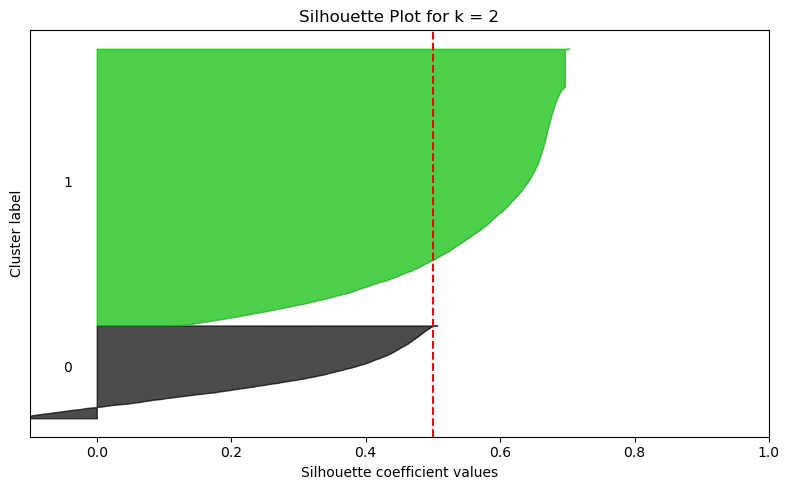

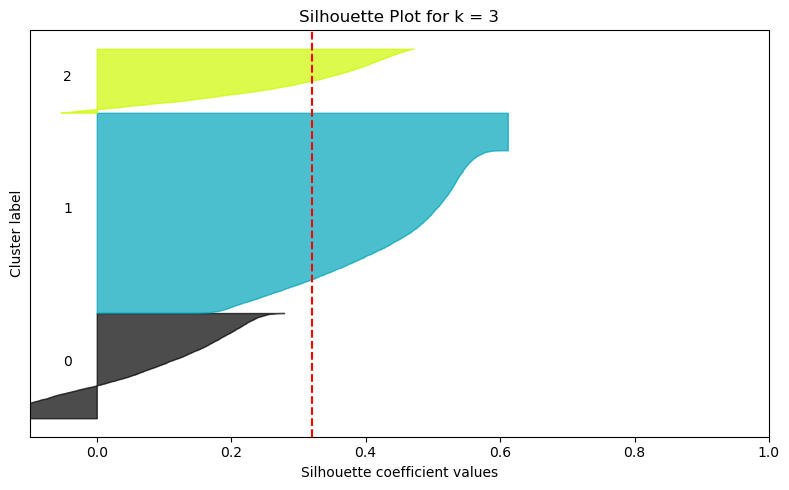

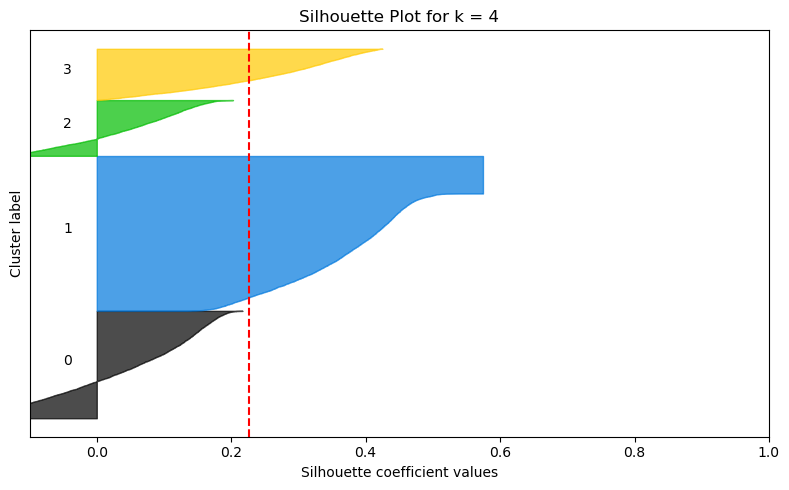

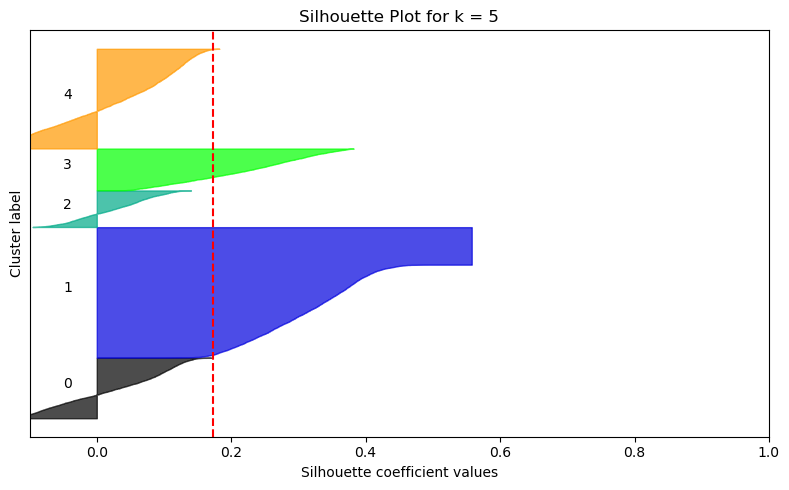

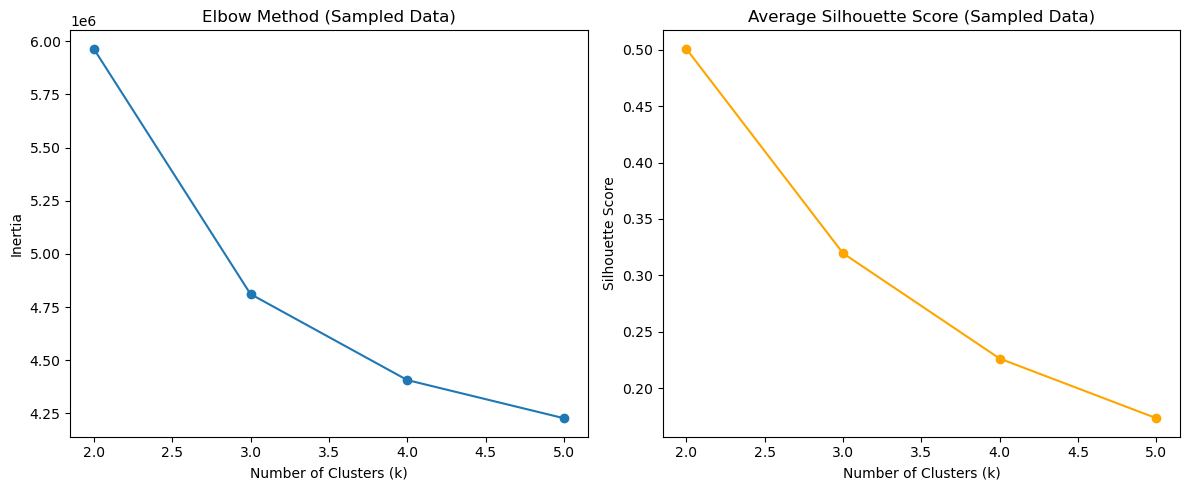

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# === STEP 1: Sample the data ===
sample_size = 20000
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data_scaled_df.shape[0], size=sample_size, replace=False)
sample = data_scaled_df.iloc[sample_idx]

# === STEP 2: Try different cluster counts and plot silhouette plots ===
range_n_clusters = list(range(2, 6))
inertias = []
silhouette_scores = []

for k in range_n_clusters:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)

    # Run KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(sample)

    # Inertia and silhouette scores
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sample, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # Add space between clusters

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette Plot for k = {k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_yticks([])  # Clear the y-axis labels
    ax.set_xlim([-0.1, 1])
    plt.tight_layout()
    plt.show()

# === STEP 3: Plot elbow and silhouette scores ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertias, marker='o')
plt.title("Elbow Method (Sampled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title("Average Silhouette Score (Sampled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


The Elbow method and the Silhouette scores are essentially in complete agreement about the optimal number of clusters.  Both seem to indicate nice clustering at n=2 clusters, but there is also a strong case to be made for n=3 by them both. The truth is that they don't seem to indicate a perfectly optimal number, and based on the silhouette plots we can see that even at n=2 or n=3, the data isn't well clustered, perhaps suggesting that this dataset doesn't have very many or meaningful "low-density zones" which are a requirement for clustering methods such as K-Means. We'll go ahead and apply K-Means using n=[2,3,4] and save the results for now so we can colour the PCA plots later using the respective cluster labels.

In [11]:
# Fit KMeans for k = 2, k = 3, and k = 4 on full standardized data
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_2 = kmeans_2.fit_predict(data_scaled_df)

kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_3 = kmeans_3.fit_predict(data_scaled_df)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_4 = kmeans_4.fit_predict(data_scaled_df)

clustered_df = pd.DataFrame(data_scaled_df, columns=[f"var_{i}" for i in range(data_scaled_df.shape[1])])
clustered_df["cluster_2"] = labels_2
clustered_df["cluster_3"] = labels_3
clustered_df["cluster_4"] = labels_4

## 1c Dimensionality Reduction

In [12]:
from sklearn.decomposition import PCA

# Run PCA on full standardized data
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Explained variance for each component
print("Explained variance ratio (PC1–PC3):", pca.explained_variance_ratio_)

Explained variance ratio (PC1–PC3): [0.67922796 0.03655754 0.03006363]


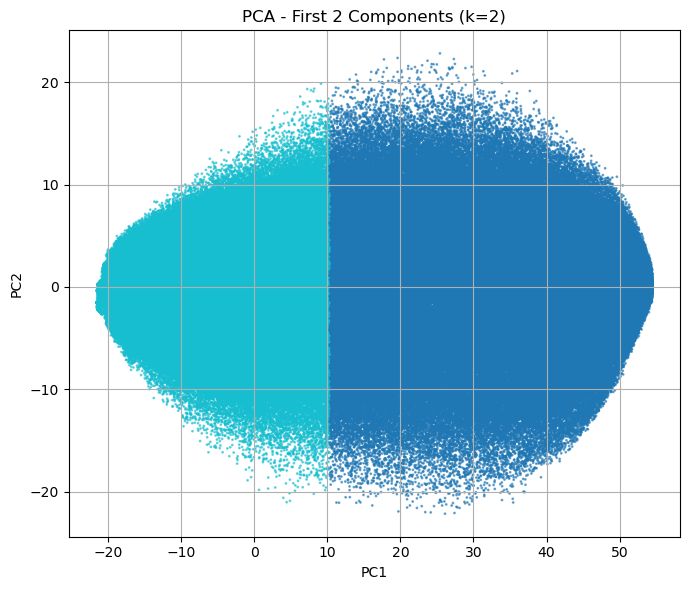

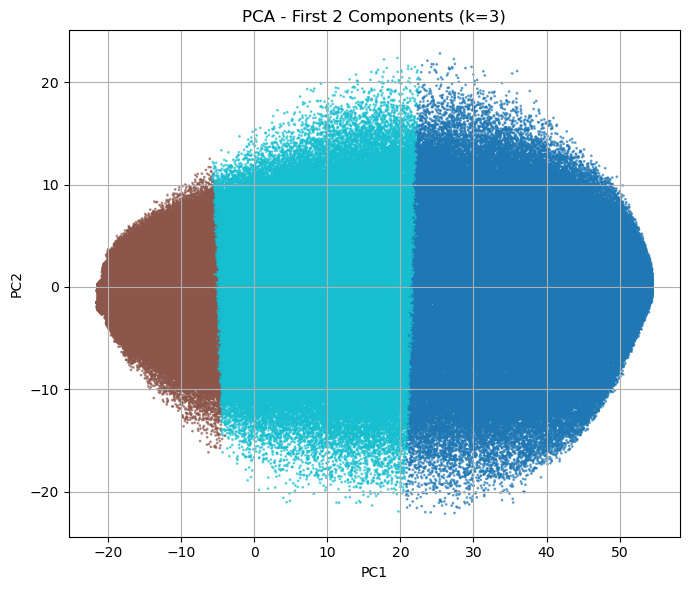

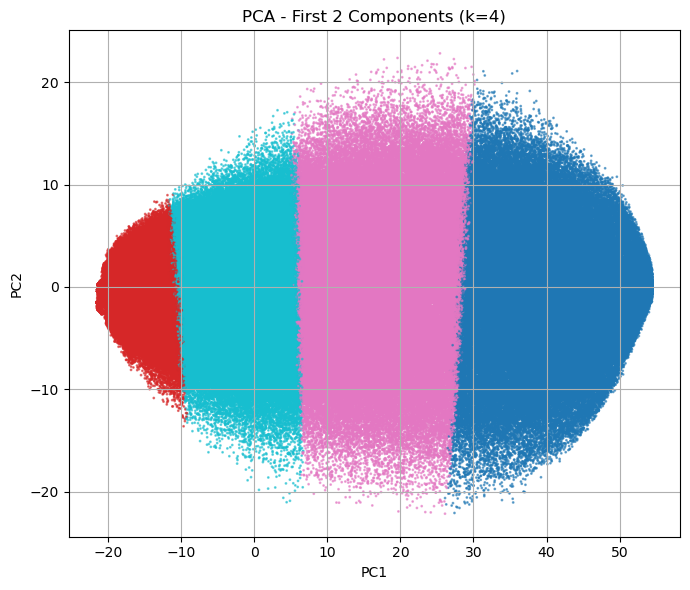

In [14]:
def plot_clusters(pca_data, labels, k):
    plt.figure(figsize=(7, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', s=1, alpha=0.6)
    plt.title(f"PCA - First 2 Components (k={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for k = 2, k = 3, and k = 4
plot_clusters(pca_data, labels_2, k=2)
plot_clusters(pca_data, labels_3, k=3)
plot_clusters(pca_data, labels_4, k=4)

In [29]:
# Create PCA loadings dataframe
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=data.columns
).reset_index().rename(columns={"index": "Variable"})

# Grab desired columns from each metadata source
household_subset = household_meta[["Variable", "Description", "Variable Type"]].rename(
    columns={
        "Description": "HS Description",
        "Variable Type": "HS Type"
    }
)

demostats_subset = demostats_meta[["Variable", "Category"]].rename(
    columns={"Category": "DS Category"}
)

# Merge both into PCA loadings
pca_loadings = pca_loadings.merge(household_subset, on="Variable", how="left")
pca_loadings = pca_loadings.merge(demostats_subset, on="Variable", how="left")

# Compute absolute contributions
for pc in ["PC1", "PC2", "PC3"]:
    pca_loadings[f"abs_{pc}"] = pca_loadings[pc].abs()

# Filter and display contributors
threshold = 0.03

for pc in ["PC1", "PC2", "PC3"]:
    sorted_vars = pca_loadings.sort_values(f"abs_{pc}", ascending=False)

    display_columns = ["Variable", "HS Description", "HS Type", "DS Category", pc]

    # Show top 10 only
    top_vars = sorted_vars.head(10)[display_columns]

    # Show all with >3% contribution (uncomment to use this instead)
    # top_vars = sorted_vars[sorted_vars[f"abs_{pc}"] > threshold][display_columns]

    print(f"\nTop contributors to {pc} (top 10):")
    display(top_vars)



Top contributors to PC1 (top 10):


,Variable,HS Description,HS Type,DS Category,PC1
341,ECYHOMSING,NaN,NaN,Household Population by Language Spoken Most O...,0.047905
332,ECYMOTSING,NaN,NaN,Household Population by Mother Tongue,0.047891
213,ECYMOBHPOP,NaN,NaN,Household Population by 5-Year Mobility,0.047889
323,ECYAIDHPOP,NaN,NaN,Household Population by Indigenous Identity,0.047882
363,ECYRIMHPOP,NaN,NaN,Household Population by Recent Immigrants (201...,0.047882
340,ECYHOMHPOP,NaN,NaN,Household Population by Language Spoken Most O...,0.047882
331,ECYMOTHPOP,NaN,NaN,Household Population by Mother Tongue,0.047882
347,ECYTIMHPOP,NaN,NaN,Household Population by Total Immigrants and P...,0.047882
154,ECYHSZTPER,NaN,NaN,Households by Size of Household,0.047882
384,ECYGENHPOP,NaN,NaN,Household Population by Generation Status,0.047882



Top contributors to PC2 (top 10):


,Variable,HS Description,HS Type,DS Category,PC2
477,HSSH037A,Wood and other fuel for heating and cooking fo...,Consumption,NaN,0.115180
98,ECYHTAMED,NaN,NaN,Total Household Population by Age,0.115050
37,ECYPTAMED,NaN,NaN,Total Population by Age,0.112423
118,ECYHMAMED,NaN,NaN,Male Household Population by Age,0.104441
469,HSSH034,Other fuel,Consumption,NaN,0.102540
57,ECYPMAMED,NaN,NaN,Male Population by Age,0.102137
476,HSSH037,Wood and other fuel for heating and cooking,Consumption,NaN,0.102082
474,HSSH036A,Propane for heating and cooking for owned prin...,Consumption,NaN,0.101938
471,HSSH035A,Heating oil charges for owned principal residence,Consumption,NaN,0.099963
470,HSSH035,Heating oil,Consumption,NaN,0.096659



Top contributors to PC3 (top 10):


,Variable,HS Description,HS Type,DS Category,PC3
417,HSWH040S,Net purchase price of owned residences,Consumption,NaN,0.131642
232,ECYSTYAPU5,NaN,NaN,Occupied Private Dwellings by Structure Type,-0.130740
334,ECYMOTFREN,NaN,NaN,Household Population by Mother Tongue,-0.128383
231,ECYSTYAPT,NaN,NaN,Occupied Private Dwellings by Structure Type,-0.125147
343,ECYHOMFREN,NaN,NaN,Household Population by Language Spoken Most O...,-0.123145
196,ECYHFSCL,NaN,NaN,Census Family Households by Family Structure,-0.122392
218,ECYTENRENT,NaN,NaN,Occupied Private Dwellings by Tenure,-0.121469
414,HSTE001ZBS,Total non-current consumption,Consumption,NaN,0.120201
197,ECYHFSCLNC,NaN,NaN,Census Family Households by Family Structure,-0.119985
163,ECYHTY1PH,NaN,NaN,Households by Household Type,-0.119002


In [30]:
# Create a unified category column with fallback logic
pca_loadings["Unified Category"] = pca_loadings["DS Category"].fillna(pca_loadings["HS Type"])

# Melt the data to long format for easier groupby
melted = pca_loadings.melt(
    id_vars=["Unified Category"],
    value_vars=["abs_PC1", "abs_PC2", "abs_PC3"],
    var_name="Component",
    value_name="AbsContribution"
)

# Clean component names (e.g., "abs_PC1" → "PC1")
melted["Component"] = melted["Component"].str.replace("abs_", "")

# Group and sum contributions
grouped = (
    melted.groupby(["Component", "Unified Category"])["AbsContribution"]
    .sum()
    .reset_index()
    .sort_values(["Component", "AbsContribution"], ascending=[True, False])
)

# Display top 20 contributors for each component
for pc in ["PC1", "PC2", "PC3"]:
    print(f"\nTop 20 aggregated contributions by category for {pc}:")
    top20 = grouped[grouped["Component"] == pc].head(20)
    display(top20)



Top 20 aggregated contributions by category for PC1:


,Component,Unified Category,AbsContribution
3,PC1,Consumption,9.501046
41,PC1,Total Household Population by Age,0.807046
0,PC1,Basics,0.799976
42,PC1,Total Population by Age,0.799806
4,PC1,Female Household Population by Age,0.738022
5,PC1,Female Population by Age,0.732894
34,PC1,Male Household Population by Age,0.708034
35,PC1,Male Population by Age,0.702860
8,PC1,Household Population 15 Years or Over by Industry,0.569862
1,PC1,Census Families by Family Structure,0.557291



Top 20 aggregated contributions by category for PC2:


,Component,Unified Category,AbsContribution
46,PC2,Consumption,7.766291
77,PC2,Male Household Population by Age,0.772505
78,PC2,Male Population by Age,0.770342
84,PC2,Total Household Population by Age,0.766550
85,PC2,Total Population by Age,0.763344
69,PC2,Household Population by Total Immigrants and P...,0.717586
47,PC2,Female Household Population by Age,0.613599
48,PC2,Female Population by Age,0.612054
66,PC2,Household Population by Period of Immigration,0.530933
59,PC2,Household Population by Age at Immigration,0.510121



Top 20 aggregated contributions by category for PC3:


,Component,Unified Category,AbsContribution
89,PC3,Consumption,6.581515
88,PC3,Census Family Households by Family Structure,0.768410
112,PC3,Household Population by Total Immigrants and P...,0.563872
87,PC3,Census Families by Family Structure,0.563856
114,PC3,Households by Household Type,0.540118
128,PC3,Total Population by Age,0.539278
127,PC3,Total Household Population by Age,0.520398
91,PC3,Female Population by Age,0.491336
90,PC3,Female Household Population by Age,0.477615
124,PC3,Occupied Private Dwellings by Structure Type,0.453003


In [ ]:
# Create DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])
pca_df["cluster_2"] = labels_2
pca_df["cluster_3"] = labels_3
pca_df["cluster_4"] = labels_4

# Mean values for each component per cluster
mean_pcs_k2 = pca_df.groupby("cluster_2")[["PC1", "PC2", "PC3"]].mean()
mean_pcs_k3 = pca_df.groupby("cluster_3")[["PC1", "PC2", "PC3"]].mean()
mean_pcs_k4 = pca_df.groupby("cluster_4")[["PC1", "PC2", "PC3"]].mean()

print("\nMean PC values per cluster (k=2):")
print(mean_pcs_k2)

print("\nMean PC values per cluster (k=3):")
print(mean_pcs_k3)

print("\nMean PC values per cluster (k=4):")
print(mean_pcs_k4)


Mean PC values per cluster (k=3):
                  PC1        PC2       PC3
cluster_3                                 
0          127.106046  19.145049  2.229789
1           -1.256719  -0.089678 -0.015181
2          685.591596 -72.595933 -0.092623

Mean PC values per cluster (k=4):
                  PC1        PC2       PC3
cluster_4                                 
0           52.882152  24.650250  2.084549
1           -1.781812  -0.388583 -0.045080
2          919.872347 -78.562783 -5.250304
3          285.211537 -35.869501  3.523483
